In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.graph_objects as go
import requests
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor


In [3]:
file_path = '/content/drive/MyDrive/Assignments/Zoho ML Engineer Rotten Tomatoes Models/Dataset/Rotten_Tomatoes_Movies3.xls'
df = pd.read_excel(file_path)

In [4]:
df.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0


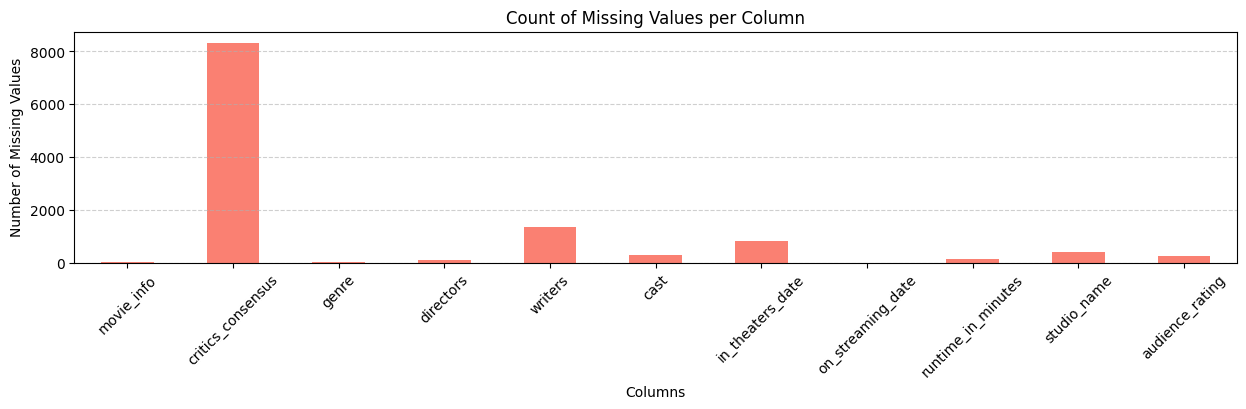

In [5]:
# Calculate the count of missing values for each column
missing_values = df.isnull().sum()

# Filter out columns with no missing values
missing_values = missing_values[missing_values > 0]

# Plot the missing values as a bar chart
plt.figure(figsize=(15, 3))
missing_values.plot(kind='bar', color='salmon')
plt.title('Count of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [6]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

null_non_null = df.isnull().sum().sum()
non_null = df.size - null_non_null

fig = go.Figure()

fig.add_trace(go.Pie(
    labels=['Null', 'Non-Null'],
    values=[null_non_null, non_null],
    hole=0.3,
    name='Null vs Non-Null',
    hoverinfo='label+value+percent',
    textinfo='label+value'
))

fig.add_trace(go.Pie(
    labels=missing_values.index,
    values=missing_values,
    hole=0.3,
    name='Missing Values Distribution',
    hoverinfo='label+value+percent',
    textinfo='label+value'
))

fig.update_layout(
    title_text="Missing Values Analysis",
    grid=dict(rows=1, columns=2),
    showlegend=True,
    annotations=[
        dict(
            text=f"Total Nulls: {null_non_null}\nTotal Non-Nulls: {non_null}",
            x=0.5, y=1.1,
            font_size=15,
            showarrow=False
        ),
        dict(
            text=f"Missing Values per Column\nTotal: {missing_values.sum()}",
            x=0.75, y=0.5,
            font_size=15,
            showarrow=False
        )
    ]
)


fig.show()

In [7]:
def map_critics_consensus(rating):
    if rating >= 85:
        return 'Superb'
    elif rating >= 75:
        return 'Very Good'
    elif rating >= 65:
        return 'Good'
    elif rating >= 50:
        return 'Average'
    elif rating >= 30:
        return 'Below Average'
    else:
        return 'Poor'

df['critics_consensus'] = df['audience_rating'].apply(map_critics_consensus)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   16638 non-null  object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  16638 non-null  int64     

In [9]:
df.isnull().sum()

,0
movie_title,0
movie_info,24
critics_consensus,0
rating,0
genre,17
directors,114
writers,1349
cast,284
in_theaters_date,815
on_streaming_date,2


In [10]:
len(df)

16638

In [11]:
df.isnull().sum().sum()

3428

In [12]:
df.isnull().values.any()

True

In [13]:
df['cast'].fillna('Unknown', inplace=True)
df['runtime_in_minutes'].fillna(df['runtime_in_minutes'].median(), inplace=True)
df['movie_info'].fillna('Unknown', inplace=True)

<ipython-input-13-09ec2490da2a>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-13-09ec2490da2a>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

In [14]:
df['rating'].value_counts()

,count
rating,
R,6136
NR,4862
PG-13,2885
PG,2062
G,652
NC17,37
PG-13),3
R),1


In [15]:
df['rating'] = df['rating'].replace('R)', 'R')
df['rating'] = df['rating'].replace('PG-13)', 'PG-13')

In [16]:
null_genre_rows = df[df['genre'].isnull()]
print(null_genre_rows[['rating', 'genre']])

      rating genre
1927   PG-13   NaN
2449      NR   NaN
3088   PG-13   NaN
3091      PG   NaN
3100      PG   NaN
4751       R   NaN
5125      NR   NaN
8121       R   NaN
8359   PG-13   NaN
9197      NR   NaN
9509      NR   NaN
11266     NR   NaN
13238      R   NaN
13955  PG-13   NaN
13958     NR   NaN
14371     NR   NaN
16433     NR   NaN


In [17]:
print(null_genre_rows['rating'].unique())

['PG-13' 'NR' 'PG' 'R']


In [18]:
df_expanded = df.assign(genre=df['genre'].str.split(',')).explode('genre')
genre_counts = df_expanded.groupby(['rating', 'genre']).size().reset_index(name='count')

max_genres = genre_counts.loc[genre_counts.groupby('rating')['count'].idxmax()]

print(max_genres)

    rating           genre  count
10       G   Kids & Family    306
32    NC17           Drama     20
55      NR           Drama   1680
92      PG           Drama    613
142  PG-13          Comedy    933
160      R           Drama   2073


In [19]:
max_genres_to_replace_null_values = {
    'PG-13': 'Comedy',
    'NR': 'Drama',
    'PG': 'Drama',
    'R': 'Drama'
}

df['genre'] = df.apply(
    lambda row: max_genres_to_replace_null_values[row['rating']] if pd.isnull(row['genre']) else row['genre'],
    axis=1
)

In [20]:
unique_genres = []

for row in df['genre']:
    genres = row.split(',')

    for genre in genres:
      trimmed_genre = genre.strip()
      if trimmed_genre not in unique_genres:
          unique_genres.append(trimmed_genre)

print(unique_genres)
print(len(unique_genres))

['Action & Adventure', 'Comedy', 'Drama', 'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family', 'Mystery & Suspense', 'Western', 'Art House & International', 'Horror', 'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest', 'Sports & Fitness', 'Television', 'Musical & Performing Arts', 'Cult Movies', 'Anime & Manga', 'Gay & Lesbian']
21


In [21]:
df.isnull().sum()

,0
movie_title,0
movie_info,0
critics_consensus,0
rating,0
genre,0
directors,114
writers,1349
cast,0
in_theaters_date,815
on_streaming_date,2


In [22]:
studio_director_relation = df.groupby('rating')['directors'].unique()

print(studio_director_relation)

rating
G        [Richard Fleischer, Will Vinton, Andy Byatt, A...
NC17     [Todd Haynes, Sean Mathias, Michael Cuesta, Mi...
NR       [Sidney Lumet, Alfred Hitchcock, Delmer Daves,...
PG       [Chris Columbus, Adam Thomas Anderegg, Mary Mc...
PG-13    [Roland Emmerich, Hideo Nakata, Kevin Reynolds...
R        [Nicole Holofcener, Blake Edwards, Jonathan Ka...
Name: directors, dtype: object


In [23]:
director_count = df.groupby(['rating', 'directors']).size().reset_index(name='count')
max_directors = director_count.loc[director_count.groupby('rating')['count'].idxmax()]

print(max_directors)

     rating         directors  count
399       G  Robert Stevenson     10
514    NC17  Pedro Almod√≥var      4
2258     NR         John Ford     21
4178     PG  Alfred Hitchcock     17
7268  PG-13       Woody Allen     16
7900      R    Clint Eastwood     22


In [24]:
director_count = df.groupby(['rating', 'directors']).size().reset_index(name='count')
max_directors = director_count.loc[director_count.groupby('rating')['count'].idxmax()]

max_directors_dict = max_directors.set_index('rating')['directors'].to_dict()

print(max_directors_dict)

df['directors'] = df.apply(
    lambda row: max_directors_dict.get(row['rating'], row['directors']) if pd.isnull(row['directors']) else row['directors'],
    axis=1
)

{'G': 'Robert Stevenson', 'NC17': 'Pedro Almod√≥var', 'NR': 'John Ford', 'PG': 'Alfred Hitchcock', 'PG-13': 'Woody Allen', 'R': 'Clint Eastwood'}


In [25]:
writer_count = df.groupby(['rating', 'writers']).size().reset_index(name='count')

max_writers = writer_count.loc[writer_count.groupby('rating')['count'].idxmax()]

max_writers_dict = max_writers.set_index('rating')['writers'].to_dict()

df['writers'] = df.apply(
    lambda row: max_writers_dict.get(row['rating'], row['writers']) if pd.isnull(row['writers']) else row['writers'],
    axis=1
)

In [26]:
df.isnull().sum()

,0
movie_title,0
movie_info,0
critics_consensus,0
rating,0
genre,0
directors,0
writers,0
cast,0
in_theaters_date,815
on_streaming_date,2


In [27]:
studio_count = df.groupby(['directors', 'studio_name']).size().reset_index(name='count')

max_studio_per_director = studio_count.loc[studio_count.groupby('directors')['count'].idxmax()]

director_to_studio = max_studio_per_director.set_index('directors')['studio_name'].to_dict()

df['studio_name'] = df.apply(
    lambda row: director_to_studio.get(row['directors'], row['studio_name'])
    if pd.isnull(row['studio_name']) else row['studio_name'],
    axis=1
)

most_used_studio = df['studio_name'].mode()[0]

df['studio_name'] = df['studio_name'].fillna(most_used_studio)

In [28]:
df.isnull().sum()

,0
movie_title,0
movie_info,0
critics_consensus,0
rating,0
genre,0
directors,0
writers,0
cast,0
in_theaters_date,815
on_streaming_date,2


In [29]:
# Function to get the Date of Birth of the director from Wikipedia
def get_director_dob(director_name):
    try:
        # Create a Wikipedia search URL
        search_url = f"https://en.wikipedia.org/wiki/{'_'.join(director_name.split())}"
        response = requests.get(search_url)
        response.raise_for_status()  # Check if the request was successful

        # Parse the HTML content
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract the birth date (usually in the first infobox table)
        infobox = soup.find('table', class_='infobox')
        if infobox:
            dob = infobox.find('span', class_='bday')
            if dob:
                return dob.text  # Return the date in 'YYYY-MM-DD' format
            else:
                # If only the year is available, return it in 'YYYY' format
                dob_year = infobox.find('span', class_='birthdate')
                if dob_year:
                    return dob_year.text.split(' ')[0]  # Return only the year
    except Exception as e:
        print(f"Error fetching DOB for {director_name}: {e}")
    return None

# Step 1: Identify rows where in_theaters_date is null
missing_date_rows = df[df['in_theaters_date'].isnull()]

# Step 2: Create a dictionary to store the directors and their corresponding estimated in_theaters_date
directors_dob_40_years = {}

# Loop through the rows with missing in_theaters_date
for idx, row in missing_date_rows.iterrows():
    director = row['directors']

    # Fetch the director's DOB if not already fetched
    if director not in directors_dob_40_years:
        dob = get_director_dob(director)

        if dob:
            # Check if DOB is just a year (e.g., '1950')
            if len(dob) == 4:  # Year only
                dob = dob + "-01-01"  # Add a default month and day (e.g., January 1st)

            # Convert DOB to datetime object
            dob_datetime = datetime.strptime(dob, '%Y-%m-%d')

            # Add 40 years to DOB
            estimated_date = dob_datetime + timedelta(days=40 * 365.25)  # Approx 40 years in days
            directors_dob_40_years[director] = estimated_date.date()  # Store the estimated date

    # Replace the missing in_theaters_date with the calculated value
    if director in directors_dob_40_years:
        df.at[idx, 'in_theaters_date'] = directors_dob_40_years[director]

# Display the updated DataFrame
print(df)


<ipython-input-29-b452bd207fff>:55: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1960-01-30' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.



Error fetching DOB for Sean Ellis (II): 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Sean_Ellis_(II)
Error fetching DOB for Arthur Rankin Jr., Jules Bass, Takeya Nakamura: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Arthur_Rankin_Jr.,_Jules_Bass,_Takeya_Nakamura
Error fetching DOB for Bob Misiorowski: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Bob_Misiorowski
Error fetching DOB for David Novack: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/David_Novack
Error fetching DOB for Joe Dante, Ken Russell, Sean S. Cunningham, Monte Hellman, John Gaeta: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Joe_Dante,_Ken_Russell,_Sean_S._Cunningham,_Monte_Hellman,_John_Gaeta
Error fetching DOB for Caitlin Koller: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Caitlin_Koller
Error fetching DOB for Dylan Reynolds: 404 Client Error: Not Found for url: https://en.wikipedia.org

In [30]:
df.isnull().sum()

,0
movie_title,0
movie_info,0
critics_consensus,0
rating,0
genre,0
directors,0
writers,0
cast,0
in_theaters_date,497
on_streaming_date,2


In [31]:
df.dropna(subset=['in_theaters_date'], inplace=True)

<ipython-input-32-4aa6b96b4c30>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




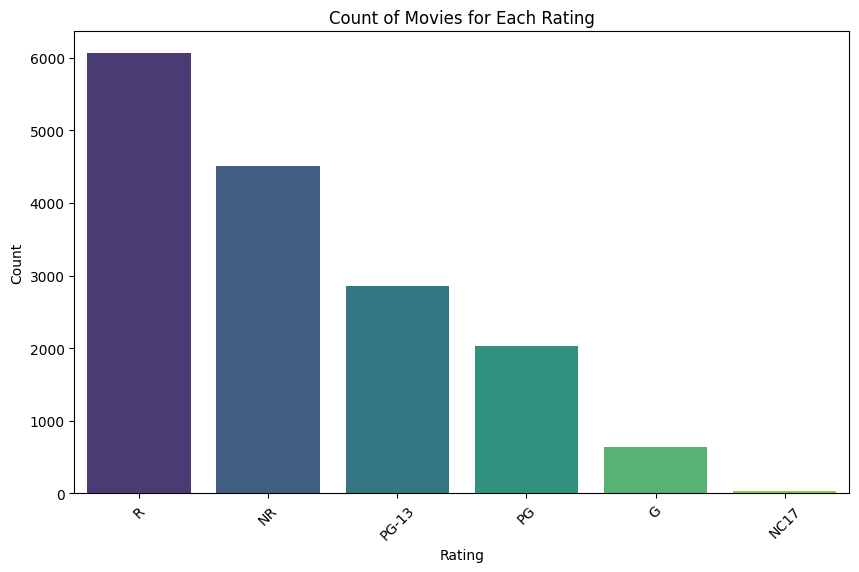

In [32]:
# Count the occurrences of each rating
rating_counts = df['rating'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")

# Add titles and labels
plt.title('Count of Movies for Each Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

# Display the plot
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

<ipython-input-33-214eb65d2947>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




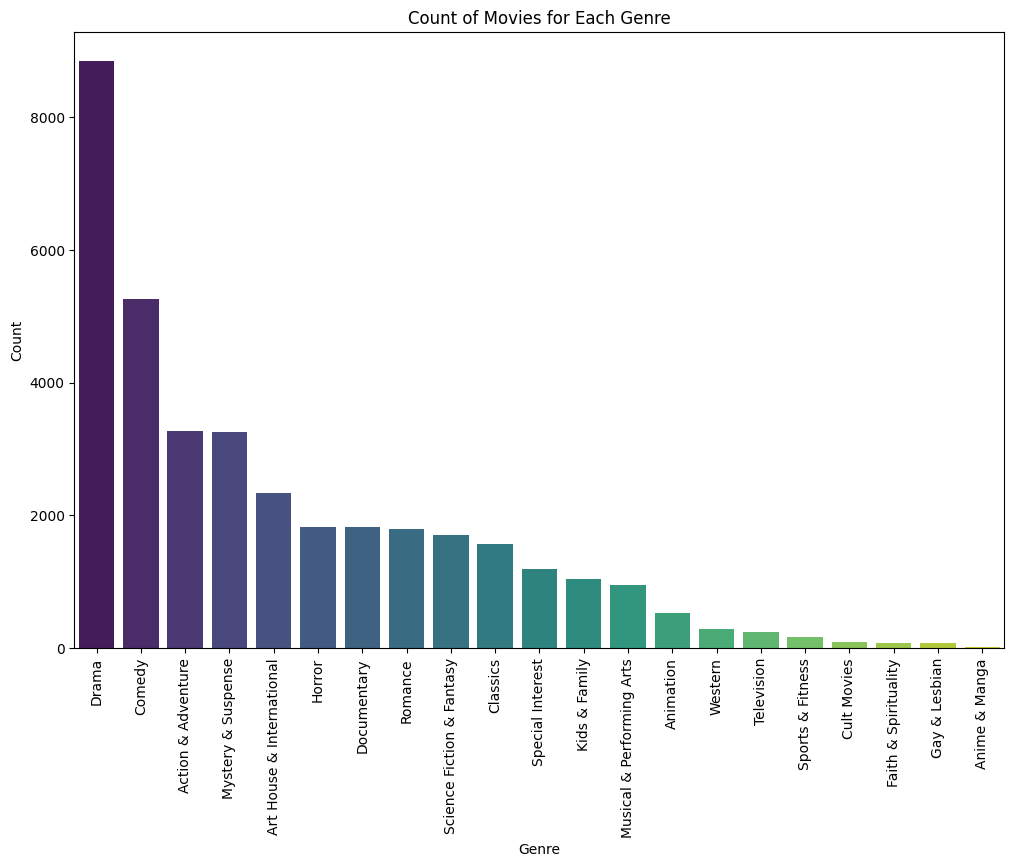

In [33]:
all_genres = []

# Loop through each row and extract genres
for row in df['genre']:
    genres = row.split(',')  # Split the genre string by commas
    for genre in genres:
        trimmed_genre = genre.strip()  # Remove leading/trailing spaces
        all_genres.append(trimmed_genre)

# Count the occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")

# Add titles and labels
plt.title('Count of Movies for Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

<ipython-input-34-054e62d1e017>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




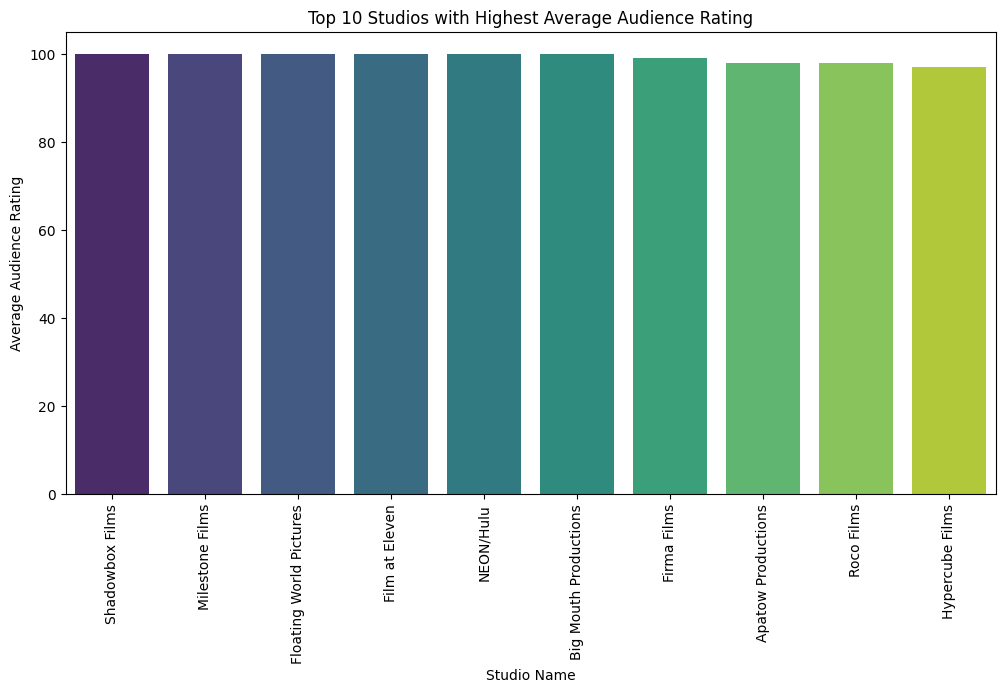

In [34]:
# Calculate the average audience rating for each studio
studio_avg_rating = df.groupby('studio_name')['audience_rating'].mean()

# Sort the studios by average rating in descending order
top_10_studios = studio_avg_rating.sort_values(ascending=False).head(10)

# Create a barplot for the top 10 studios
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_studios.index, y=top_10_studios.values, palette='viridis')

# Set plot labels and title
plt.title('Top 10 Studios with Highest Average Audience Rating')
plt.xlabel('Studio Name')
plt.ylabel('Average Audience Rating')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

<ipython-input-35-1c92820a42ca>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




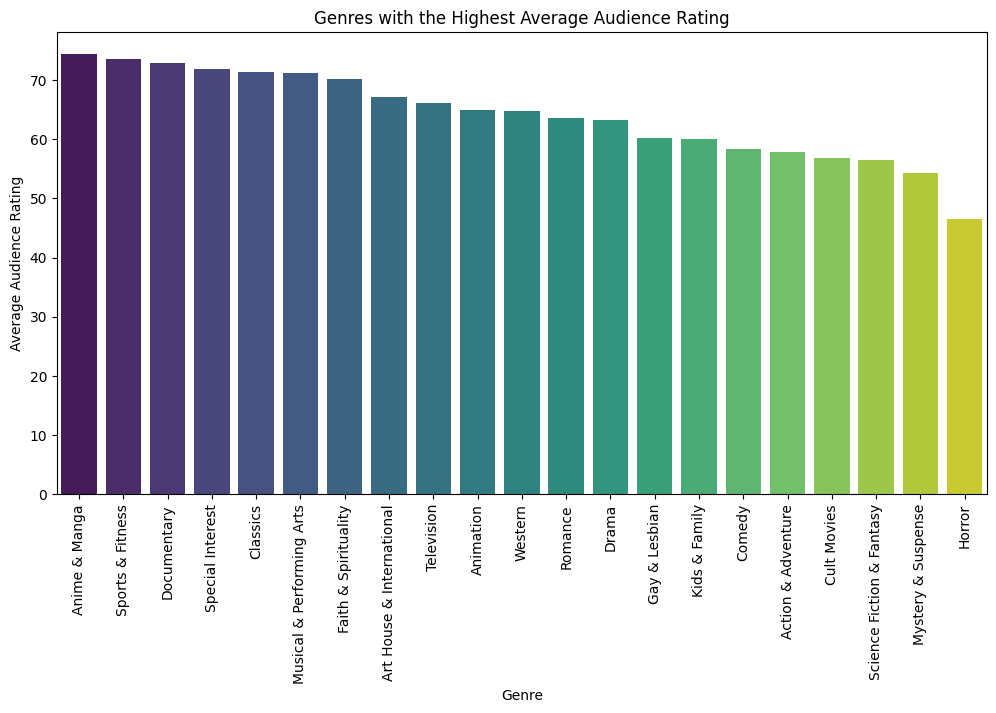

In [35]:
# Split the genres into a list and explode them into individual rows
df_exploded_genres = df['genre'].str.split(',').explode().str.strip()

# Add the corresponding audience ratings to the exploded genres
df_exploded_genres = df_exploded_genres.to_frame(name='genre')
df_exploded_genres['audience_rating'] = df.loc[df_exploded_genres.index, 'audience_rating'].values

# Calculate the average audience rating for each genre
genre_avg_rating = df_exploded_genres.groupby('genre')['audience_rating'].mean()

# Sort genres by average audience rating in descending order
top_genres = genre_avg_rating.sort_values(ascending=False)

# Create a barplot for the top genres
plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres.index, y=top_genres.values, palette='viridis')

# Set plot labels and title
plt.title('Genres with the Highest Average Audience Rating')
plt.xlabel('Genre')
plt.ylabel('Average Audience Rating')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

<ipython-input-36-f92f710b01ec>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




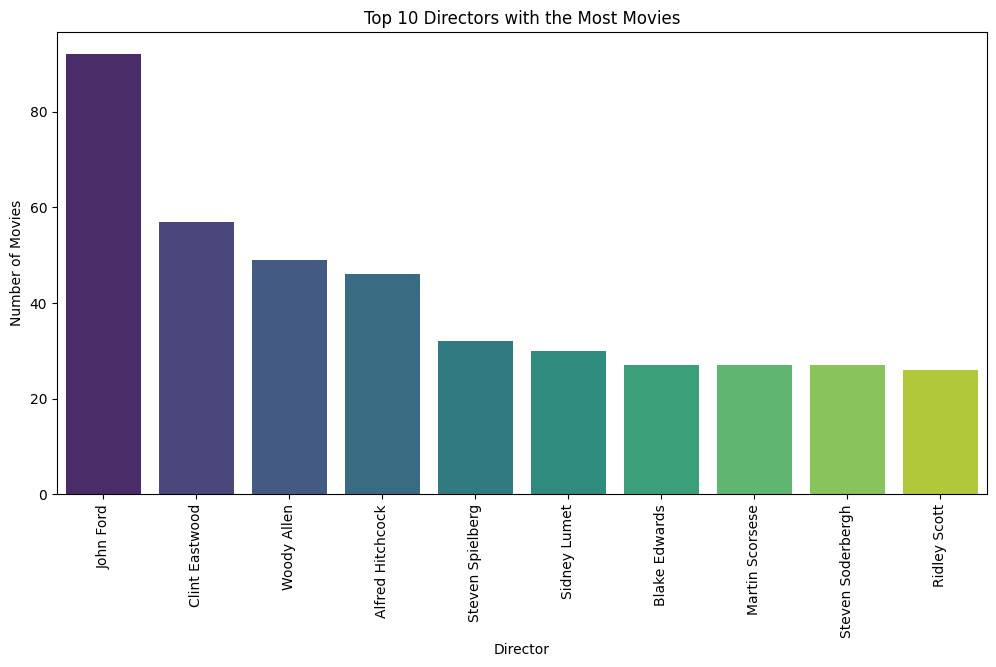

In [36]:
# Count the number of movies directed by each director
director_counts = df['directors'].value_counts()

# Get the top 10 directors with the most movies
top_10_directors = director_counts.head(10)

# Create a barplot to visualize the top 10 directors with the most movies
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_directors.index, y=top_10_directors.values, palette='viridis')

# Set plot labels and title
plt.title('Top 10 Directors with the Most Movies')
plt.xlabel('Director')
plt.ylabel('Number of Movies')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

<ipython-input-37-050f6758ddc5>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




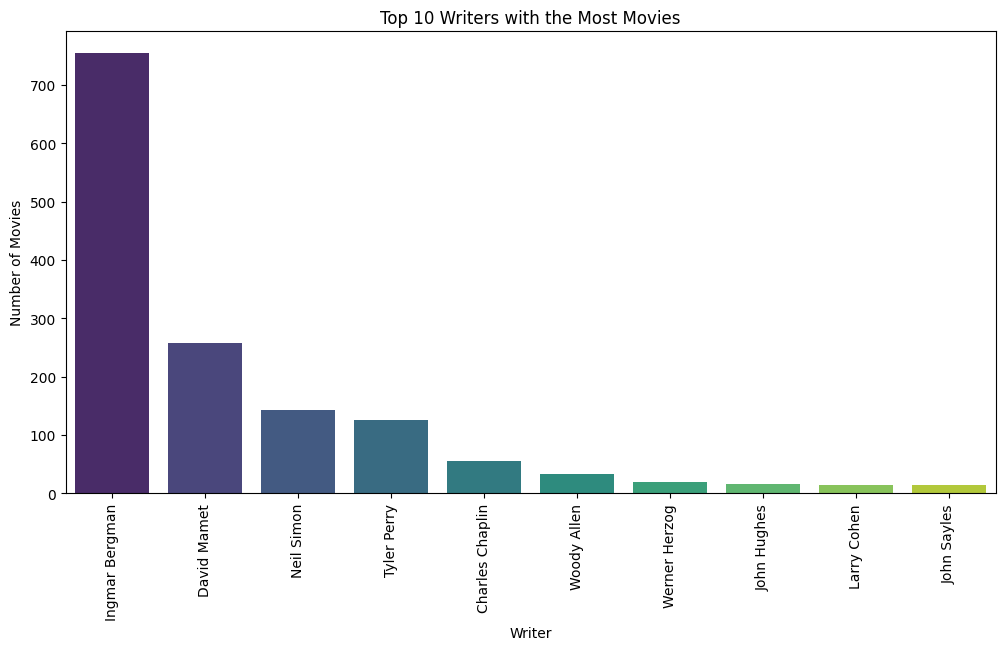

In [37]:
# Count the number of movies written by each writer
writer_counts = df['writers'].value_counts()

# Get the top 10 writers with the most movies
top_10_writers = writer_counts.head(10)

# Create a barplot to visualize the top 10 writers with the most movies
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_writers.index, y=top_10_writers.values, palette='viridis')

# Set plot labels and title
plt.title('Top 10 Writers with the Most Movies')
plt.xlabel('Writer')
plt.ylabel('Number of Movies')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

<ipython-input-38-cc75b6208034>:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




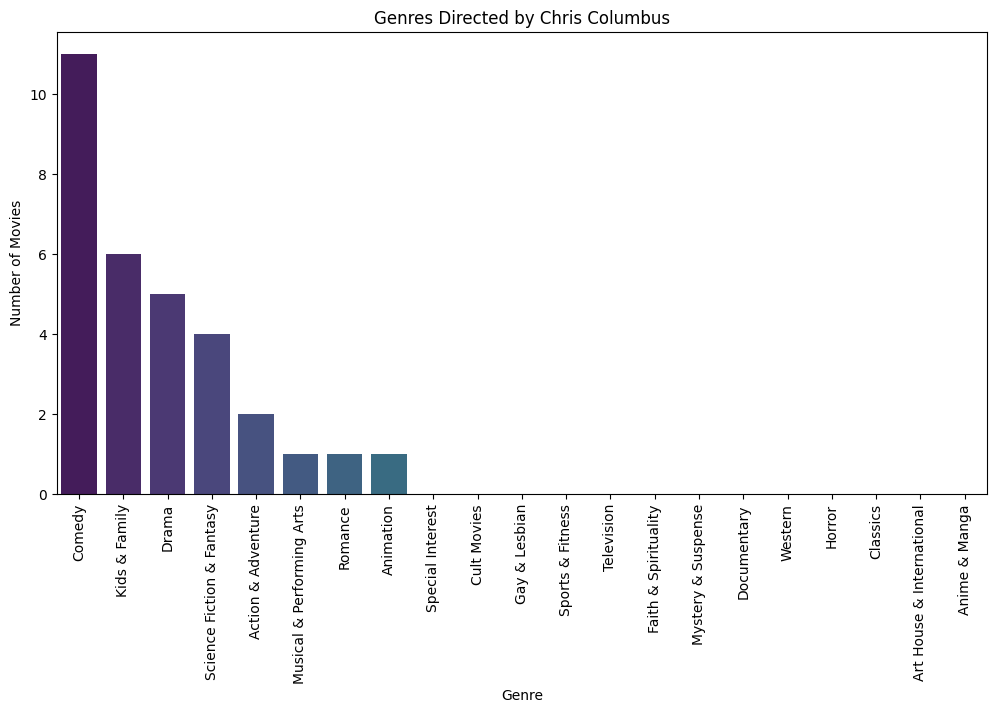

In [38]:
# Split genres and associate them with the directors
directors_genre_counts = {}

for index, row in df.iterrows():
    genres = row['genre'].split(',')  # Split the genres
    director = row['directors']

    # For each genre, associate it with the director
    for genre in genres:
        genre = genre.strip()  # Clean the genre name
        if director not in directors_genre_counts:
            directors_genre_counts[director] = {}
        if genre not in directors_genre_counts[director]:
            directors_genre_counts[director][genre] = 0
        directors_genre_counts[director][genre] += 1

# Convert the dictionary into a DataFrame for better visualization
directors_genre_df = pd.DataFrame.from_dict(directors_genre_counts, orient='index').fillna(0)

# Plot the data - Example: top genres for a selected director
director = 'Chris Columbus'  # Replace with the director you are interested in

# Get the top genres for the selected director
director_genres = directors_genre_df.loc[director].sort_values(ascending=False)

# Create a bar plot to show the genres for this director
plt.figure(figsize=(12, 6))
sns.barplot(x=director_genres.index, y=director_genres.values, palette='viridis')

# Set plot labels and title
plt.title(f"Genres Directed by {director}")
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [39]:
# Drop rows with missing target column (`audience_rating`)
df.dropna(subset=['audience_rating'], inplace=True)

In [40]:
df.isnull().sum()

,0
movie_title,0
movie_info,0
critics_consensus,0
rating,0
genre,0
directors,0
writers,0
cast,0
in_theaters_date,0
on_streaming_date,0


In [41]:
# Convert 'in_theaters_date' and 'on_streaming_date' to datetime format
df['in_theaters_date'] = pd.to_datetime(df['in_theaters_date'], errors='coerce')
df['on_streaming_date'] = pd.to_datetime(df['on_streaming_date'], errors='coerce')

# Extract year and month after conversion
df['in_theaters_year'] = df['in_theaters_date'].dt.year.fillna(0).astype(int)
df['in_theaters_month'] = df['in_theaters_date'].dt.month.fillna(0).astype(int)
df['on_streaming_year'] = df['on_streaming_date'].dt.year.fillna(0).astype(int)


In [42]:
# Create a LabelEncoder instance
le = LabelEncoder()

# Convert columns to strings to ensure uniformity
df['genre_encoded'] = le.fit_transform(df['genre'].fillna('Unknown').astype(str))
df['rating_encoded'] = le.fit_transform(df['rating'].astype(str))
df['studio_encoded'] = le.fit_transform(df['studio_name'].fillna('Unknown').astype(str))
df['tomatometer_status_encoded'] = le.fit_transform(df['tomatometer_status'].astype(str))


In [43]:
tfidf = TfidfVectorizer(max_features=100)

# Example for 'movie_info'
movie_info_tfidf = tfidf.fit_transform(df['movie_info'].fillna('')).toarray()

In [44]:
# Length of critics_consensus
df['critics_consensus_length'] = df['critics_consensus'].apply(lambda x: len(str(x)))


In [45]:
df.drop(['critics_consensus', 'movie_title', 'movie_info', 'genre', 'rating', 'studio_name',
         'directors', 'writers', 'cast', 'in_theaters_date', 'on_streaming_date',
         'tomatometer_status'], axis=1, inplace=True)

In [46]:
df.head()

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,in_theaters_year,in_theaters_month,on_streaming_year,genre_encoded,rating_encoded,studio_encoded,tomatometer_status_encoded,critics_consensus_length
0,83.0,49,144,53.0,2010,2,2010,212,3,6,2,7
1,90.0,86,140,64.0,2010,4,2010,741,5,2191,0,7
2,118.0,68,22,53.0,1979,10,1997,846,5,2593,1,7
3,95.0,100,51,97.0,1957,4,2001,678,2,619,0,6
4,127.0,89,27,74.0,1954,1,2003,279,0,682,1,4


In [47]:
scaler = StandardScaler()
numerical_cols = ['runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [48]:
# Combine all features for modeling
X = df.drop('audience_rating', axis=1)
y = df['audience_rating']

In [49]:
X.head()

,runtime_in_minutes,tomatometer_rating,tomatometer_count,in_theaters_year,in_theaters_month,on_streaming_year,genre_encoded,rating_encoded,studio_encoded,tomatometer_status_encoded,critics_consensus_length
0,-0.791041,-0.392728,1.274026,2010,2,2010,212,3,6,2,7
1,-0.511741,0.903183,1.214423,2010,4,2010,741,5,2191,0,7
2,0.605459,0.272740,-0.543859,1979,10,1997,846,5,2593,1,7
3,-0.312241,1.393527,-0.111739,1957,4,2001,678,2,619,0,6
4,0.964560,1.008257,-0.469356,1954,1,2003,279,0,682,1,4


In [50]:
y.head()

,audience_rating
0,53.0
1,64.0
2,53.0
3,97.0
4,74.0


In [51]:
df.to_csv("processed_data.csv")

In [52]:
df = pd.read_csv('/content/processed_data.csv')

In [53]:
scaler = StandardScaler()


columns_to_scale = [
    'audience_rating',
    'in_theaters_year',
    'in_theaters_month',
    'on_streaming_year',
    'genre_encoded',
    'rating_encoded',
    'studio_encoded',
    'tomatometer_status_encoded',
    'critics_consensus_length'
]

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


In [54]:
# Combine all features for modeling
X = df.drop('audience_rating', axis=1)
y = df['audience_rating']


In [55]:
df.head()

,Unnamed: 0,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,in_theaters_year,in_theaters_month,on_streaming_year,genre_encoded,rating_encoded,studio_encoded,tomatometer_status_encoded,critics_consensus_length
0,0,-0.791041,-0.392728,1.274026,-0.372507,0.557474,-1.273900,0.329011,-1.629449,-0.375885,-2.018557,0.997779,-0.265167
1,1,-0.511741,0.903183,1.214423,0.166101,0.557474,-0.705102,0.329011,0.193649,1.021362,0.801705,-1.678801,-0.265167
2,2,0.605459,0.272740,-0.543859,-0.372507,-1.022497,1.001291,-1.694098,0.555511,1.021362,1.320581,-0.340511,-0.265167
3,3,-0.312241,1.393527,-0.111739,1.781926,-2.143767,-0.705102,-1.071603,-0.023469,-1.074509,-1.227335,-1.678801,-0.572062
4,4,0.964560,1.008257,-0.469356,0.655745,-2.296668,-1.558298,-0.760355,-1.398546,-2.471756,-1.146018,-0.340511,-1.185853


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
pip install scikit-learn==1.0.2

In [60]:
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('svr', SVR(kernel='rbf')),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42))
]

#
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=RandomForestRegressor())

models = {
    'Stacking Regressor': stacking_model,
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost Regressor': XGBRegressor(n_estimators=100, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR(kernel='rbf'),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5)
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  #

    #  RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5

    #  R² Score
    r2 = r2_score(y_test, y_pred)


    print(f"{name} RMSE: {rmse:.4f}, R²: {r2:.4f}")


Stacking Regressor RMSE: 0.4151, R²: 0.8307
Gradient Boosting RMSE: 0.4077, R²: 0.8367
XGBoost Regressor RMSE: 0.4131, R²: 0.8323
Random Forest RMSE: 0.4015, R²: 0.8416
Support Vector Regressor RMSE: 1.0140, R²: -0.0104
KNN Regressor RMSE: 1.0334, R²: -0.0495


In [62]:
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}


rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


gb_model = GradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)



# Gradient Boosting
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid_search.fit(X_train, y_train)

# Random Forest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# XGBoost
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)


print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)
print("Best score for Gradient Boosting:", -gb_grid_search.best_score_ ** 0.5)  # RMSE

print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best score for Random Forest:", -rf_grid_search.best_score_ ** 0.5)  # RMSE

print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best score for XGBoost:", -xgb_grid_search.best_score_ ** 0.5)  # RMSE


Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best score for Gradient Boosting: nan
Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Random Forest: nan
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best score for XGBoost: nan


<ipython-input-62-05c1c334f63d>:47: RuntimeWarning:

invalid value encountered in scalar power

<ipython-input-62-05c1c334f63d>:50: RuntimeWarning:

invalid value encountered in scalar power

<ipython-input-62-05c1c334f63d>:53: RuntimeWarning:

invalid value encountered in scalar power

